In [46]:
%matplotlib inline

In [47]:
# imports
from __future__ import print_function
import warnings; warnings.simplefilter('ignore')
import sys
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.linear_model import LinearRegression as lr
from sklearn.ensemble import GradientBoostingRegressor as gb
from sklearn.svm import SVC
from sklearn.linear_model import ElasticNet as en
from sklearn import preprocessing
from sklearn.linear_model import Lasso as las
from sklearn.linear_model import BayesianRidge as br
from sklearn.preprocessing import StandardScaler as sc
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [48]:
#Data frame
df = pd.read_csv('~/Desktop/data/kinase_files/KinaseP00533.csv')
df.head()

,Unnamed: 0,target_id,pAc,smiles,SlogP,SMR,LabuteASA,TPSA,AMW,ExactMW,...,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
0,2609,P00533,1.60,C1=CC(=CC=C1CCC(=O)C2=C(C=C(C=C2O)O)O)O,2.3245,72.1947,114.921781,97.99,274.272,274.084124,...,0,0,0,2,0,0,0,0,0,0
1,2610,P00533,1.72,C1=CC(=C(C=C1/C=C/C(=O)C2=C(C(=C(C=C2)O[C@H]3[...,-0.4162,107.3029,180.820025,197.37,450.396,450.116212,...,0,0,0,3,0,0,0,0,0,0
2,2611,P00533,1.96,C[C@@H](C(=O)N1CCN(CC1)C2=CC(=C(C=C2NC(=O)C=C)...,3.3508,156.8052,240.763560,137.22,577.045,576.200029,...,0,0,1,4,0,0,0,0,2,1
3,2612,P00533,1.99,COC1=C(C=C(C(=C1)N2CCN(CC2)C(=O)N3CCNCC3)NC(=O...,3.4686,169.9561,259.003075,132.26,617.114,616.242563,...,0,0,1,5,0,0,0,0,2,1
4,2613,P00533,2.00,CN(C)CC(=O)N1CCN(CC1)C2=CC(=C(C=C2NC(=O)C=C)NC...,3.5316,163.6784,248.094102,120.23,590.088,589.231664,...,0,0,1,4,0,0,0,0,2,1


In [49]:
def model_eval(model):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    model_score = model.score(X_test,y_test)
    model_mse =  mse(y_test,pred)
    model_r2 =r2(y_test,pred)
    return(model_score, model_mse, model_r2)

In [50]:
#Check the shape of the dataframe
df.shape

(4639, 120)

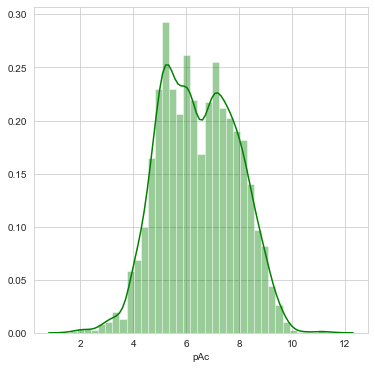

In [51]:
#Plot distribution of the pAc with the density estimation function
f, ax = plt.subplots(figsize=(6, 6))
sns.distplot(df.pAc,color = 'green');
sns.set_style("whitegrid")


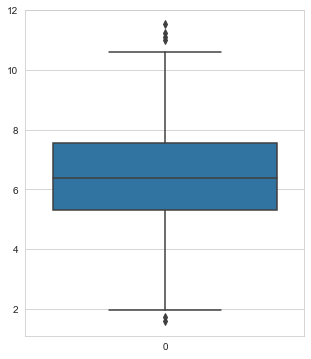

In [52]:
#Boxplot of pAc,It has a few outliers but the distribution in fairly normal
f, ax = plt.subplots(figsize=(5, 6))
sns.set_style("whitegrid")
data = df.pAc
sns.boxplot(data=data);

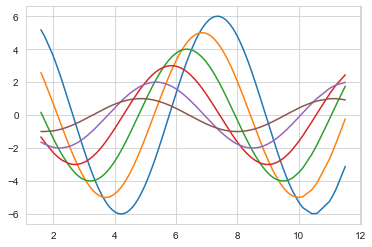

In [53]:
def sinplot(flip=1):
    x = df.pAc
    for i in range(1, 7):
        plt.plot(x, np.sin(x + i * .5) * (7 - i) * flip)
sinplot()

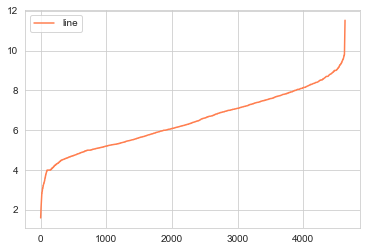

In [54]:
#line plot
ax = sns.lineplot(data=df["pAc"], color="coral", label="line")

In [55]:
#Drop unwanted colum(unnamed)
df = df.drop(['Unnamed: 0','smiles','target_id'], axis=1)
df.head()

,pAc,SlogP,SMR,LabuteASA,TPSA,AMW,ExactMW,NumLipinskiHBA,NumLipinskiHBD,NumRotatableBonds,...,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
0,1.60,2.3245,72.1947,114.921781,97.99,274.272,274.084124,5,4,4,...,0,0,0,2,0,0,0,0,0,0
1,1.72,-0.4162,107.3029,180.820025,197.37,450.396,450.116212,11,8,6,...,0,0,0,3,0,0,0,0,0,0
2,1.96,3.3508,156.8052,240.763560,137.22,577.045,576.200029,12,3,8,...,0,0,1,4,0,0,0,0,2,1
3,1.99,3.4686,169.9561,259.003075,132.26,617.114,616.242563,13,3,7,...,0,0,1,5,0,0,0,0,2,1
4,2.00,3.5316,163.6784,248.094102,120.23,590.088,589.231664,12,2,9,...,0,0,1,4,0,0,0,0,2,1


In [56]:
def add_gausian(y,mu,sigma):
    noise = np.random.normal(mu,sigma,[4639,117])
    df_aug = df +noise 
    df_new = pd.concat([df,df_aug])
    return(df_aug)
add_gausian(df,0,0.1)
    

,pAc,SlogP,SMR,LabuteASA,TPSA,AMW,ExactMW,NumLipinskiHBA,NumLipinskiHBD,NumRotatableBonds,...,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
0,1.411431,2.217135,72.199919,114.847160,98.020940,274.225697,274.111994,4.958405,3.853243,3.870276,...,0.092751,0.102933,0.022477,1.741958,0.070885,-0.048462,0.006216,-0.027310,-0.100373,0.264839
1,1.760499,-0.449021,107.246983,180.793043,197.414996,450.405594,450.308483,10.782568,8.147786,6.045374,...,0.073862,-0.166470,0.139064,2.998656,0.083022,0.273289,0.075774,0.172561,-0.136699,-0.149462
2,1.853452,3.348019,156.673438,240.698509,137.096903,576.815185,576.301111,11.910635,2.986353,7.936367,...,0.040037,0.057663,0.994819,4.032150,0.097876,-0.089062,-0.136680,-0.071793,1.925792,1.086209
3,1.902404,3.480045,169.975234,258.928305,132.190028,617.001445,616.228239,12.979342,3.054351,6.872487,...,0.085530,0.009548,0.962637,5.017924,-0.215118,0.247609,0.072162,-0.055331,1.960183,0.791481
4,2.085984,3.556439,163.779234,248.009965,120.268430,590.101886,589.289282,11.946625,1.900095,9.000192,...,0.074816,-0.012807,0.940553,3.926511,-0.043301,-0.026927,-0.071522,-0.098598,1.946095,0.922875
5,2.040133,3.089511,158.742836,241.337514,143.045901,576.160385,575.450872,12.021014,3.870075,7.985080,...,-0.037089,0.083734,1.003474,4.027414,0.147410,-0.009304,-0.040493,0.094156,1.903015,1.071093
6,2.253800,3.203239,158.859947,241.435378,128.901670,576.041202,575.227071,12.045011,3.066806,9.039079,...,0.104900,0.144332,0.950637,4.003870,-0.028647,0.061866,-0.034095,-0.015676,2.012606,1.123900
7,2.117366,1.589425,46.574928,76.447783,67.900215,172.309400,172.013025,2.982347,0.943029,2.001396,...,0.223291,0.062853,-0.117271,0.940855,0.148999,-0.123514,0.077803,0.071233,-0.032624,0.028445
8,2.276029,4.146516,170.764907,259.501120,129.058408,616.164165,615.372241,12.054822,2.987672,8.060331,...,0.059461,-0.188079,1.187732,5.102835,-0.079200,0.064659,-0.003326,0.015842,1.890942,1.036630
9,2.195502,4.131254,170.775775,259.741211,129.290901,616.202120,615.237804,12.071353,3.065155,8.104715,...,-0.085994,0.079721,0.916236,4.864538,0.064204,0.010888,0.136039,-0.124532,1.876072,1.038945


In [57]:
#make a data directory and a target_ifles folder
#import os

#os.mkdir('C:/Users/aboagyeso/Desktop/data/augmented_files')

In [58]:
#Check the content of the data folder
#os.listdir('C:/Users/aboagyeso/Desktop/data')

In [59]:
#Adding guasian noise iteratively 
def add_gausian():
    mu=0 
    noise = np.random.normal(mu,sigma,[4639,117])
    #sigma=[0.1,0.2,0.3,0.4,0.5]
    df_aug = df + noise
    df_new = pd.concat([df, df_aug])


In [60]:
def add_gausian(df,sigma):
    noise = np.random.normal(mu,sigma,[4639,117])
    df_aug = df +noise 
    df_new = pd.concat([df,df_aug])
    return(df_aug)
add_gausian(df,0.1)

NameError: name 'mu' is not defined

In [61]:
#Adding Guasian noise to augment the data 
mu,sigma = 0,0.1 
noise = np.random.normal(mu,sigma,[4639,117])

P00533_aug = df+noise
#print(P00533_aug.head())
P00533_aug.to_csv("P00533_augmented.csv")
P00533_aug.to_csv('~/Desktop/data/augmented_files/P00533_aug.csv')
P00533_aug.head()

,pAc,SlogP,SMR,LabuteASA,TPSA,AMW,ExactMW,NumLipinskiHBA,NumLipinskiHBD,NumRotatableBonds,...,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
0,1.563555,2.421763,72.204521,114.835633,98.025572,274.419188,273.963131,4.949163,3.941063,3.880258,...,-0.014190,-0.092423,-0.084189,2.091460,0.065900,-0.074383,-0.150171,-0.052920,0.027643,-0.154075
1,1.596474,-0.533092,107.541232,180.946751,197.546652,450.319813,450.140324,10.988896,7.820157,5.732714,...,-0.016197,-0.018695,0.011344,3.054570,0.154197,0.158246,0.015012,0.007935,-0.023732,-0.147108
2,1.824149,3.238611,157.077405,240.792946,137.009428,577.052248,576.160194,12.071708,3.162878,7.980100,...,-0.180068,0.017139,1.008331,3.879554,0.136241,0.102440,-0.089778,-0.105967,1.718724,1.037116
3,1.975970,3.488345,169.897749,259.019601,132.246834,617.105877,616.110158,12.883635,2.949150,7.049170,...,-0.032406,0.023577,0.989876,5.047596,-0.035236,0.004403,0.112503,0.078078,2.053832,0.996628
4,1.882405,3.608350,163.743183,248.021168,120.178374,590.143646,589.217779,11.966972,2.041945,8.882297,...,-0.139481,-0.027402,0.982147,3.953234,-0.049767,-0.018474,0.037753,0.162347,1.941581,1.072087


In [62]:
print(P00533_aug.shape)
print(df.shape)

(4639, 117)
(4639, 117)


In [63]:
#Appending the 2 dataframes
df_new = pd.concat([df, P00533_aug])
df_new.head()

,pAc,SlogP,SMR,LabuteASA,TPSA,AMW,ExactMW,NumLipinskiHBA,NumLipinskiHBD,NumRotatableBonds,...,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
0,1.60,2.3245,72.1947,114.921781,97.99,274.272,274.084124,5.0,4.0,4.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.72,-0.4162,107.3029,180.820025,197.37,450.396,450.116212,11.0,8.0,6.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.96,3.3508,156.8052,240.763560,137.22,577.045,576.200029,12.0,3.0,8.0,...,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,2.0,1.0
3,1.99,3.4686,169.9561,259.003075,132.26,617.114,616.242563,13.0,3.0,7.0,...,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,2.0,1.0
4,2.00,3.5316,163.6784,248.094102,120.23,590.088,589.231664,12.0,2.0,9.0,...,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,2.0,1.0


In [64]:
#shape of dataframe plus the augmented data
df_new.shape

(9278, 117)

In [65]:
# Get the feature vector
#X = df.drop('smiles', 'mol', 'pAc', axis=1)
X = df_new.drop(columns=['pAc'],axis=1).values
# Get the target vector
y = df_new["pAc"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)
print(model_eval(rf()))

(0.7205230889609172, 0.560325505461081, 0.7205230889609172)


In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
my_pipeline = make_pipeline(Imputer(), RandomForestRegressor())

In [67]:
cv_results = cross_validate(rf(), X, y, cv=10)
sorted(cv_results.keys())
this_scores = cross_val_score(rf(), X, y, cv=10, n_jobs=1)
print(this_scores)
this_scores.mean()

[-3.15782128 -8.44693648 -6.40280802 -5.77200865 -5.9970861  -2.11305483
 -4.47446982 -3.02479736 -3.22301512 -6.51175824]


-4.912375590658614

In [69]:
from sklearn.model_selection import cross_val_score
scores2 = cross_val_score(my_pipeline, X, y, scoring='neg_mean_absolute_error')
print(scores)
print(scores.mean())

[-1.12479139 -1.74884375 -1.81319428]
-1.5622764709120778


In [ ]:
print('Mean Absolute Error %2f' %(-1 *scores.mean()))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
my_pipeline = make_pipeline(Imputer(), RandomForestRegressor())

In [ ]:
print(model_eval(SVR()))

In [ ]:
#Add guasian noise mean = 0, std_dev = 0.2
mu,sigma = 0,0.2
noise = np.random.normal(mu,sigma,[4639,117])

P00533_aug2 = df+noise
P00533_aug2.head()

In [ ]:
#Appending the 2 dataframes
df_new2 = pd.concat([df_new, P00533_aug2])
df_new2.head()

In [ ]:
#The shape of the new dataframe after augmenting for the second time with a mu,sigma of 0,0.2
df_new2.shape

In [ ]:
# Get the feature vector
#X = df.drop('smiles', 'mol', 'pAc', axis=1)
X = df_new2.drop(columns=['pAc'],axis=1).values
# Get the target vector
y = df_new2["pAc"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=30)
print(model_eval(rf()))

In [ ]:
#Add guasian noise mean = 0, std_dev = 0.3
mu,sigma = 0,0.3
noise = np.random.normal(mu,sigma,[4639,117])

P00533_aug3 = df+noise
df_new3 = pd.concat([df_new2, P00533_aug3])
df_new.head()

In [ ]:
df_new3.shape

In [ ]:
# Get the feature vector
#X = df.drop('smiles', 'mol', 'pAc', axis=1)
X = df_new3.drop(columns=['pAc'],axis=1).values
# Get the target vector
y = df_new3["pAc"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=30)
print(model_eval(rf()))

In [ ]:
#Add guasian noise mean = 0, std_dev = 0.4
mu,sigma = 0,0.4
noise = np.random.normal(mu,sigma,[4639,117])

P00533_aug4 = df+noise
df_new4 = pd.concat([df_new3, P00533_aug4])
df_new4.head()

In [ ]:
df_new4.shape

In [ ]:
# Get the feature vector
#X = df.drop('smiles', 'mol', 'pAc', axis=1)
X = df_new4.drop(columns=['pAc'],axis=1).values
# Get the target vector
y = df_new4["pAc"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=30)
print(model_eval(rf()))

In [ ]:
#Add guasian noise mean = 0, std_dev = 0.5
mu,sigma = 0,0.5
noise = np.random.normal(mu,sigma,[4639,117])

P00533_aug5 = df+noise
df_new5 = pd.concat([df_new4, P00533_aug5])
df_new5.head()

In [ ]:
df_new5.shape

In [ ]:
# Get the feature vector
#X = df.drop('smiles', 'mol', 'pAc', axis=1)
X = df_new5.drop(columns=['pAc'],axis=1).values
# Get the target vector
y = df_new5["pAc"].values 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)
#Random Forest 
print(model_eval(rf()))

In [ ]:
def model_eval(model):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    model_score = model.score(X_test,y_test)
    model_mse =  mse(y_test,pred)
    model_r2 =r2(y_test,pred)
    return(model_score, model_mse, model_r2)

In [ ]:
#Linear Regression
print(model_eval(lr()))

In [ ]:
#Random Forest 
print(model_eval(rf()))

In [ ]:
df_new.describe()

In [ ]:
#Check the distribution of the target after the 2nd augmentation 
#Plot distribution of the pAc with the density estimation function
x = df_new.pAc
sns.distplot(x,color = 'purple');

In [ ]:
x.plot(color = 'red')

In [ ]:
#Augment the dataframe again with mu,sigma = 0,0.3


In [ ]:
#Summary statistics of the pAc
df_stat = df.describe()
df_stat

In [ ]:
# Get the feature vector
#X = df.drop('smiles', 'mol', 'pAc', axis=1)
#X = df.drop(columns=['target_id','smiles', 'pAc'],axis=1).values
# Get the target vector
#y = df["pAc"].values

In [ ]:
X

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)

In [ ]:
#Scale the data  
from sklearn.preprocessing import StandardScaler

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)

plt.figure(1, figsize=(14, 13))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

##### After performing pca,less than 10 components can explain over 95% of variance

In [ ]:
#Plot distribution of the pAc with the density estimation function
x = df.pAc
sns.distplot(x);

In [ ]:
#histogram and normal probability plot
from scipy.stats import norm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.distplot(df['pAc'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['pAc'], plot=plt)

#The probability plot (Chambers et al., 1983) is a graphical technique 
#for assessing whether or not a data set follows a given distribution such as the normal or Weibull.
#The data are plotted against a theoretical distribution
#in such a way that the points should form approximately a straight line

In [ ]:
#applying log transformation ensures a much fitted plot
df['pAc'] = np.log(df['pAc'])
#transformed histogram and normal probability plot
sns.distplot(df['pAc'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['pAc'], plot=plt)

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(20,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
#Correlation with output variable
cor_target = abs(cor["pAc"])
#Selecting highly correlated features using a threshold of 0.26
relevant_features = cor_target[cor_target>0.26]
relevant_features

In [ ]:
#12 features seem to be the optimum no of features for our model

In [ ]:
#pAc correlation matrix
k = 12 #number of variables for heatmap
cols = corrmat.nlargest(k, 'pAc')['pAc'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
#scatterplot of top features from the correlation matrix
sns.set()
cols = ['pAc', 'slogp_VSA10', 'peoe_VSA3', 'MQN36', 'smr_VSA3', 'peoe_VSA10', 'smr_VSA6']
sns.pairplot(df[cols], size = 2.5)
plt.show();

##### Optimum number of features to be used for modeling

In [ ]:
#no of features
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
nof_list=np.arange(1,13)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

In [ ]:
#Standardize the data 
#from sklearn.preprocessing import StandardScaler

# Declare the StandardScaler
#std_scaler = StandardScaler()

# Standardize the features in the training data
#X_train = std_scaler.fit_transform(X_train)

# Standardize the features in testing data
#X_test = std_scaler.transform(X_test)
#y_train = std_scaler.fit_transform(y_train.reshape(-1,1)).reshape(-1)
#y_test = std_scaler.fit_transform(y_test.reshape(-1,1)).reshape(-1)

##### MODELING

In [ ]:
!pip install Xgboost

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

##### ElasticNet Model

In [ ]:
clf_elas = ElasticNet()
clf_elas = clf_elas.fit(X_train, y_train)
pred_elas = clf_elas.predict(X_test)
print('The MSE is :')
print(mean_squared_error(y_test, pred_elas))
print("The r2 score is:")
print(r2_score(y_test, pred_elas))
#print(clf_elas.coef_)

print(clf_elas.score(X,y))

##### BayesianRidge Model

In [ ]:
clf_bays = BayesianRidge()
clf_bays.fit(X_train, y_train)
pred_bays = clf_bays.predict(X_test)
pred_bays

##### Define a cross validation strategy

In [ ]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [ ]:
#Gradient Boosting Regression :
#With huber loss that makes it robust to outliers

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [ ]:
#XGBoost :
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [ ]:
#Train the model
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
pred